In [1]:
"""
This pickles two matching datasets, first matching up the eventnumbers and then the jets, so that the data is in the same order.
"""

import uproot
import numpy as np

def pair_datasets(filename, compressedfilename):
    file = uproot.open(filename)

    #Compressed variables have a c in them somewhere
    filec = uproot.open(compressedfilename)

    feventNumber = file["CollectionTree/EventInfoAux.eventNumber"].array()
    fceventNumber = filec["CollectionTree/EventInfoAux.eventNumber"].array()
    
    #fm = file["CollectionTree/AntiKt4EMTopoJetsAux.m"].array()
    #fphi = file["CollectionTree/AntiKt4EMTopoJetsAux.phi"].array()
    #feta = file["CollectionTree/AntiKt4EMTopoJetsAux.eta"].array()
    #fpt = file["CollectionTree/AntiKt4EMTopoJetsAux.pt"].array()

    #fm = [0]#file["CollectionTree/MuonsAux.m"].array()
    fphi = file["CollectionTree/PhotonsAuxDyn.phi"].array()
    feta = file["CollectionTree/PhotonsAuxDyn.eta"].array()
    fpt = file["CollectionTree/PhotonsAuxDyn.pt"].array()
    fm = [[1 for j in range(0,len(fphi[i]))] for i in range(0,len(fphi))]
    
    #fcm = filec["CollectionTree/AntiKt4EMTopoJetsAux.m"].array()
    #fcphi = filec["CollectionTree/AntiKt4EMTopoJetsAux.phi"].array()
    #fceta = filec["CollectionTree/AntiKt4EMTopoJetsAux.eta"].array()
    #fcpt = filec["CollectionTree/AntiKt4EMTopoJetsAux.pt"].array()
    
    #fcm = [0]#filec["CollectionTree/MuonsAux.m"].array()
    fcphi = filec["CollectionTree/PhotonsAuxDyn.phi"].array()
    fceta = filec["CollectionTree/PhotonsAuxDyn.eta"].array()
    fcpt = filec["CollectionTree/PhotonsAuxDyn.pt"].array()
    fcm = [[1 for j in range(0,len(fcphi[i]))] for i in range(0,len(fcphi))]
    
    """
    fm = file["CollectionTree/TauJetsAuxDyn.m"].array()
    fphi = file["CollectionTree/TauJetsAuxDyn.phi"].array()
    feta = file["CollectionTree/TauJetsAuxDyn.eta"].array()
    fpt = file["CollectionTree/TauJetsAuxDyn.pt"].array()
    #fm = [[1 for j in range(0,len(fphi[i]))] for i in range(0,len(fphi))]

    fcm = filec["CollectionTree/TauJetsAuxDyn.m"].array()
    fcphi = filec["CollectionTree/TauJetsAuxDyn.phi"].array()
    fceta = filec["CollectionTree/TauJetsAuxDyn.eta"].array()
    fcpt = filec["CollectionTree/TauJetsAuxDyn.pt"].array()
    #fcm = [[1 for j in range(0,len(fcphi[i]))] for i in range(0,len(fcphi))]
    """
    print(fm[0])
    print(fphi[0])
    print(feta[0])
    print(fpt[0])
    
    fevents = [[feventNumber[i], fm[i], fphi[i], feta[i], fpt[i]] for i in range(0,len(feventNumber))]

    fcevents = [[fceventNumber[i], fcm[i], fcphi[i], fceta[i], fcpt[i]] for i in range(0,len(fceventNumber))]

    fevents.sort()
    fcevents.sort()
    
    fevents = fevents[:10000]
    fcevents = fcevents[:10000]

    if len(fevents) != len(fcevents):
        raise Exception("Number of events not matching")

    for i in range(0,len(fevents)):
        if fevents[i][0] != fcevents[i][0]:
            raise Exception("Events are not matching")
            

    #Match jets by deltaR < 0.05

    def proper_phi(phi):
        if phi < -np.pi:
            return phi+2*np.pi
        if phi > np.pi:
            return phi-2*np.pi
        return phi

    def deltaR(eta1, eta2, phi1, phi2):
        deta = eta1-eta2
        dphi = proper_phi(phi1-phi2)
        return np.sqrt(deta**2+dphi**2)

    #Iterate through every event and sort jets according to the uncompressed data

    events = []
    compressed_events = []

    #Iterate through events
    for ei in range(0,len(fevents)):

        if ei % 1000 == 0:
            print(str(int(ei/len(fevents)*100)) + "%")

        m = []
        phi = []
        eta = []
        pt = []
        
        cm = []
        cphi = []
        ceta = []
        cpt = []
        
        matched = [False for x in range(0,len(fcevents[ei][1]))]
        
        #Iterate through jets in uncompressed event
        for ji in range(0,len(fevents[ei][1])):
            if fevents[ei][1][ji] != 0.:
                for jci in range(0,len(fcevents[ei][1])):

                    dR = deltaR(fevents[ei][3][ji], fcevents[ei][3][jci], fevents[ei][2][ji], fcevents[ei][2][jci])

                    ptres = (-fevents[ei][4][ji] + fcevents[ei][4][jci])/fevents[ei][4][ji]

                    if fcevents[ei][1][jci] != 0.:#fevents[ei][4][ji] > 10. and fcevents[ei][4][jci] > 10. and fcevents[ei][1][jci] != 0. and np.abs(ptres)<0.02:
                        if (dR < 0.01 and (not matched[jci]) and ptres < 0.005) :
                            cm.append(fcevents[ei][1][jci])
                            cphi.append(fcevents[ei][2][jci])
                            ceta.append(fcevents[ei][3][jci])
                            cpt.append(fcevents[ei][4][jci])
                            
                            m.append(fevents[ei][1][ji])
                            phi.append(fevents[ei][2][ji])
                            eta.append(fevents[ei][3][ji])
                            pt.append(fevents[ei][4][ji])

                            matched[jci] = True
                    
        if len(fcevents[ei][1]) == len(cm):
            compressed_events.append([fevents[ei][0], cm, cphi, ceta, cpt])
            events.append([fevents[ei][0], m, phi, eta, pt])
        else:
            pass
            #print("Jets not matched in event: " + str(fevents[ei][0]))
       
    print(str(len(compressed_events)/len(fevents)*100) + " % of events matched")
    
    return events, compressed_events

events, eventsc = pair_datasets("../../data/user.elmsheus.20339024.EXT1._000003.DAOD_PHYS.data.pool.root", "../../data/user.elmsheus.20338515.EXT1._000003.DAOD_PHYS.data.pool.root" )


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[ 2.4690354   1.6283464  -0.7682312  -0.8513578  -3.1111066  -1.7903146
  2.4748006  -0.9560885  -1.4511024  -0.9676292  -1.3606063   0.5957706
  2.0307646  -0.7490839   2.650276   -1.0183955   0.16589108 -1.6761472
  2.3729289  -0.2873217   1.5652112   0.9879146   1.3881701  -0.66209495
  3.0609927  -0.7849719  -1.7909425   1.6761079  -1.4577696   2.022943
 -2.1962652  -2.4313173  -1.5807095   2.375494   -0.5619961  -2.8762858
 -0.95636106  0.25536355  2.921604   -0.9035557   1.4010514  -2.3200037
 -1.9466406   2.7530634 ]
[-0.56197053 -0.8639987  -1.6108867  -1.4412472   0.5714459  -1.8627534
  1.5625314  -1.4397122  -0.7241982  -1.6440154   0.80066085 -0.07698729
 -0.48038745 -1.7053202   1.143723   -1.7591724  -0.43274206  0.10337172
 -1.9924567  -0.09068202  0.76638114 -1.1583169  -0.23880275  2.0256622
  1.0552739   0.1449487  -0.18575813  0.91219  

In [2]:
import pandas as pd

mcevents, mceventsc = pair_datasets("../../data/user.elmsheus.20339022.EXT1._000001.DAOD_PHYS.mc.pool.root", "../../data/user.elmsheus.20338512.EXT1._000001.DAOD_PHYS.mc.pool.root")

#Flatten lists
m = []
phi = []
eta = []
pt = []
for event in events:
    for k in range(0,len(event[1])):
        m.append(event[1][k])
        phi.append(event[2][k])
        eta.append(event[3][k])
        pt.append(event[4][k])
        
mc = []
phic = []
etac = []
ptc = []
for event in eventsc:
    for k in range(0,len(event[1])):
        mc.append(event[1][k])
        phic.append(event[2][k])
        etac.append(event[3][k])
        ptc.append(event[4][k])
        
#Create tensors
df_dict = {}
df_dict["m"] = m
df_dict["phi"] = phi
df_dict["eta"] = eta
df_dict["pt"] = pt

df = pd.DataFrame(data=df_dict)

print(df.head())

dfc_dict = {}
dfc_dict["m"] = mc
dfc_dict["phi"] = phic
dfc_dict["eta"] = etac
dfc_dict["pt"] = ptc

dfc = pd.DataFrame(data=dfc_dict)

print(dfc.head())

#Flatten lists
mmc = []
phimc = []
etamc = []
ptmc = []
for event in mcevents:
    for k in range(0,len(event[1])):
        mmc.append(event[1][k])
        phimc.append(event[2][k])
        etamc.append(event[3][k])
        ptmc.append(event[4][k])
        
mcmc = []
phicmc = []
etacmc = []
ptcmc = []
for event in mceventsc:
    for k in range(0,len(event[1])):
        mcmc.append(event[1][k])
        phicmc.append(event[2][k])
        etacmc.append(event[3][k])
        ptcmc.append(event[4][k])
        
#Create tensors
dfmc_dict = {}
dfmc_dict["m"] = mmc
dfmc_dict["phi"] = phimc
dfmc_dict["eta"] = etamc
dfmc_dict["pt"] = ptmc

dfmc = pd.DataFrame(data=dfmc_dict)

print(dfmc.head())

dfcmc_dict = {}
dfcmc_dict["m"] = mcmc
dfcmc_dict["phi"] = phicmc
dfcmc_dict["eta"] = etacmc
dfcmc_dict["pt"] = ptcmc

dfcmc = pd.DataFrame(data=dfcmc_dict)

print(dfcmc.head())

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[ 3.0180087  -0.41440764 -0.86702716 -0.3547103   2.9045606   3.0463839
  2.8337018  -0.7769967   2.1706777   1.9810776   1.6513675  -0.51231605
  2.7887561  -0.6338182  -1.8799112   1.8621757  -3.0300088  -2.422833
  2.4166782  -0.5488418  -0.03811036 -1.1165193  -0.3091663   1.9590722
  0.6626531   1.6354601 ]
[ 0.01517254  1.7942343   0.13412713  1.7944179  -0.25781733  0.11526464
 -0.23857765  0.80315375 -0.96609074 -1.1766131   2.4096913   1.9406117
 -0.81145513  1.8191574  -1.3654975  -1.1347165   0.20679338  1.173646
 -0.6597052  -2.2677536  -1.6898409  -2.297403    1.7304996  -1.0492388
 -0.6910266  -0.7678884 ]
[37224.547  14428.626   5056.921   8696.224   5491.0527  5882.6357
  4427.7144  3765.4712  4350.4736  3393.3723  3077.3523  2878.6907
  3257.8765  2541.8218  3501.3933  2480.134   2875.361   2767.3735
  2163.1218  1879.4404  3514.5994  1875.1774  1744.6129  1932.1593
  1687.3724  2146.481 ]
0

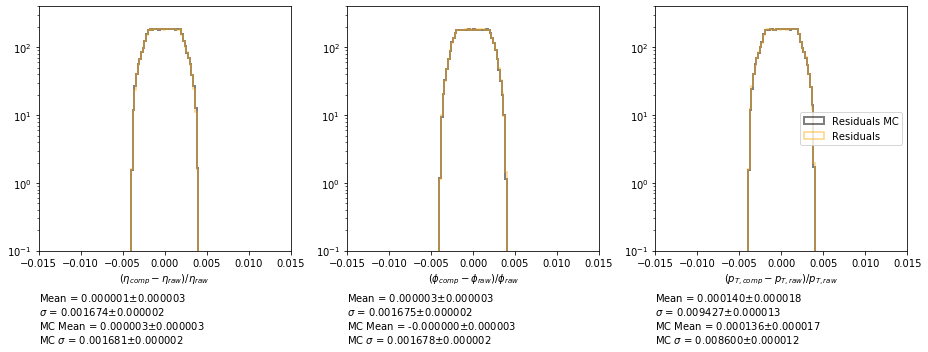

In [3]:

import sys
BIN = '../../'
sys.path.append(BIN)
import utils
import matplotlib.pyplot as plt
from scipy import stats
import my_matplotlib_style as ms

%matplotlib inline

plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$m$', r'$p_T$', r'$\phi$', r'$\eta$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']
alph = 0.5
n_bins = 200

residual_strings = [r'$(m_{comp} - m_{raw}) / m_{raw}$',
                        r'$(\eta_{comp} - \eta_{raw}) / \eta_{raw}$',
                        r'$(\phi_{comp} - \phi_{raw}) / \phi_{raw}$',
                        r'$(p_{T,comp} - p_{T,raw}) / p_{T,raw}$']


residuals = (df - dfc)/df
residualsmc = (dfmc - dfcmc)/dfmc

#residuals = residuals.loc[residuals["m"] >= 1.]
#residualsmc = residualsmc.loc[residualsmc["m"] >= 1.]

#print(residuals.head(100))

#dfmc = dfmc.loc[dfmc["pt"] != 0.0]

#respt = (np.array(pt)-np.array(ptc))/np.array(pt)

#respt = [(dfc["pt"][i]-df["pt"][i])/df["pt"][i]]

branches = ["m","eta","phi","pt"]

fig,axs = plt.subplots(1,3, figsize=(13,5))

plt.ticklabel_format(axis='both',style='sci')

#axes = [axs[0,0],axs[0,1],axs[1,0],axs[1,1]]
#fig.suptitle(r'Residuals for jets with non-zero mass (matched by $\Delta R$ < 0.05)')
axs[0].set(yscale="log")
axs[0].set(ylim=(1/10,400))
#axs[0].ticklabel_format(axis='x',style='sci')
axs[1].set(yscale="log")
axs[1].set(ylim=(1/10,400))
axs[2].set(yscale="log")
#axs[3].set(yscale="log")
axs[2].set(ylim=(1/10,400))
#axs[3].set(ylim=(1/10,400))
#axs[0].set(xlabel="(pt_out - pt_in)/pt_in")
#axs[1].set(xlabel="(eta_out - eta_in)/eta_in")
#axs[2].set(xlabel="(phi_out - phi_in)/phi_in")

#axs.ylabel('Number of particles')
#range=None
#range=(-0.02,0.02)
range=(-0.02,0.02)
for kk in np.arange(1,4):
    n_hist_pred, bin_edges, _ = axs[kk-1].hist(
        residualsmc[branches[kk]], label='Residuals MC', alpha=alph, bins=n_bins, range=range, density=True,histtype='step',color='black', linewidth=2)
    n_hist_pred, bin_edges, _ = axs[kk-1].hist(
        residuals[branches[kk]], label='Residuals', alpha=alph, bins=n_bins, range=range, density=True,histtype='step',color='orange', linewidth=1.5)
    #axs[kk].xlabel(residual_strings[kk])  # (train.columns[kk], train.columns[kk], train.columns[kk]))
    #plt.yscale("log")
    #ms.sciy()
    #plt.yscale('log')
    std = np.std(residuals[branches[kk]])
    std_err = utils.std_error(residuals[branches[kk]])
    mean = np.nanmean(residuals[branches[kk]])
    sem = stats.sem(residuals[branches[kk]], nan_policy='omit')
    stdmc = np.std(residualsmc[branches[kk]])
    std_errmc = utils.std_error(residualsmc[branches[kk]])
    meanmc = np.nanmean(residualsmc[branches[kk]])
    semmc = stats.sem(residualsmc[branches[kk]], nan_policy='omit')
    axes = plt.gca()
    axs[kk-1].set_xlim((-0.015,0.015))

    text = 'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f\nMC Mean = %f$\pm$%f\nMC $\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err, meanmc, semmc, stdmc, std_errmc)
    axs[kk-1].annotate(text, (0,0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top')
    axs[kk-1].set(xlabel=residual_strings[kk])
    #axs[kk].text(.1, .8, 'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
    #         horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12)
    #fig_name = 'trainforever_residual_%s' % branches[kk]
    

plt.legend(loc=7)
plt.tight_layout()
plt.savefig("photonsfloatresiduals.png", dpi=300)